<a href="https://colab.research.google.com/github/NathanMacktravis/ML-Projects-for-finance-/blob/main/Microsoft_Stock_Forecasting_with_LSTMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

# 1) Collect MSTF data

In [2]:
# Open the dataframe
df = pd.read_csv('/content/MSFT.csv')

In [3]:
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.061434,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063628,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064725,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.063079,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061982,47894400


In [4]:
df.shape

(9083, 7)

Columns description

- **Open** : Price from the first transaction of a trading day
- **High** : Maximum price in a trading day
- **Low**  : 	Minimum price in a trading day
- **Close** :	Price from the last transaction of a trading day
- **Adj Close** : Closing price adjusted to reflect the value after accounting for any corporate actions
- **Volume** : Number of units traded in a day

In this project, we will try to predict Close forcast values.

In [16]:
# Get infos about dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9083 entries, 0 to 9082
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       9083 non-null   object 
 1   Open       9083 non-null   float64
 2   High       9083 non-null   float64
 3   Low        9083 non-null   float64
 4   Close      9083 non-null   float64
 5   Adj Close  9083 non-null   float64
 6   Volume     9083 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 496.9+ KB


# 2) Preprocessing

## a) Convert "date" column type into datetime type

In [22]:
# choose "close" & "date" columns
df_mstf = df[['Date', 'Close']]

In [23]:
df_mstf.head()

,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090


In [24]:
import datetime

In [25]:
# Convert "date" column into datetime type using str_to_datetime function

def str_to_datetime(date) :
  split = date.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day= day)


In [26]:
# Apply str_to_datetime function into "date" column
df_mstf['Date'] = df_mstf['Date'].apply(str_to_datetime)

<ipython-input-26-2df91ff5d717>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mstf['Date'] = df_mstf['Date'].apply(str_to_datetime)


In [27]:
df_mstf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9083 entries, 0 to 9082
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    9083 non-null   datetime64[ns]
 1   Close   9083 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 142.1 KB


## b) Modify index into "Date" index

In [32]:
df_mstf_copy = df_mstf.copy()

In [33]:
# modify index of dataframe usinf "date" column
df_mstf_copy.set_index('Date', inplace=True)

In [34]:
df_mstf_copy.head()

,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090


# 3) Data Analysis

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

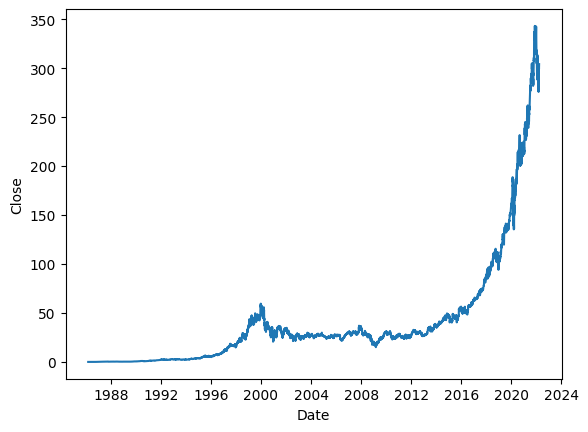

In [36]:
# Visualizing "Close" column with index
plt.plot(df_mstf_copy.index, df_mstf_copy['Close'])
plt.xlabel('Date')
plt.ylabel('Close')
plt.show()


# 4) Feature engineering

We could have used a model based on time series, such as the VAR model. But in our case, we want to use a model based on a supervised learning approach, which in this case is LSTMs.
To do that, we need to transform our dataframe into dataframe with features representing the last 3 "Close" prices and the target value "Close" representing the target value.

In [37]:
import numpy as np

In [39]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    # Convert string dates to datetime objects
    first_date = str_to_datetime(first_date_str)
    last_date = str_to_datetime(last_date_str)

    # Initialize the target date to start building windows
    target_date = first_date

    # Lists to store the results
    dates = []  # target dates
    X, Y = [], []  # input windows (X) and prediction targets (Y)

    # Flag to indicate the last iteration of the loop
    last_time = False

    # Loop indefinitely until the last_date is reached
    while True:
        # Extract a window of size (n+1) ending on the current target date
        df_subset = dataframe.loc[:target_date].tail(n + 1)

        # Verify if the extracted window has exactly (n+1) entries
        if len(df_subset) != n + 1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return

        # Convert the 'Close' prices in the subset into a NumPy array
        values = df_subset['Close'].to_numpy()

        # Separate inputs (first n values) and the target value (last value)
        x, y = values[:-1], values[-1]

        # Append data to the respective lists
        dates.append(target_date)
        X.append(x)
        Y.append(y)

        # Find the next target date (approximately one week later)
        next_week = dataframe.loc[target_date:target_date + datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year, month, day = next_date_str.split('-')
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

        # Exit the loop if this was the last iteration
        if last_time:
            break

        # Update the target date for the next iteration
        target_date = next_date

        # Check if the next iteration will be the final one
        if target_date == last_date:
            last_time = True

    # Construct a DataFrame to hold the results
    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates

    # Convert the list of windows to a NumPy array for easy indexing
    X = np.array(X)

    # Populate the DataFrame with historical target columns (lagged features)
    for i in range(0, n):
        ret_df[f'Target-{n - i}'] = X[:, i]

    # Add the final prediction target column
    ret_df['Target'] = Y

    return ret_df

In [43]:
windowed_df = df_to_windowed_df(df_mstf_copy,
                                '1986-03-18',
                                '2022-03-24',
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,1986-03-18,0.097222,0.100694,0.102431,0.099826
1,1986-03-19,0.100694,0.102431,0.099826,0.098090
2,1986-03-20,0.102431,0.099826,0.098090,0.095486
3,1986-03-21,0.099826,0.098090,0.095486,0.092882
4,1986-03-24,0.098090,0.095486,0.092882,0.090278
...,...,...,...,...,...
9075,2022-03-18,287.149994,294.390015,295.220001,300.429993
9076,2022-03-21,294.390015,295.220001,300.429993,299.160004
9077,2022-03-22,295.220001,300.429993,299.160004,304.059998
9078,2022-03-23,300.429993,299.160004,304.059998,299.489990


In [44]:
# Split our dataframe into dates, X & y
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)


In [45]:
dates, X, y = windowed_df_to_date_X_y(windowed_df)
dates.shape, X.shape, y.shape

((9080,), (9080, 3, 1), (9080,))

Now we will split our dataframe into train(80%), test(10%) and validation(10%).

In [46]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]

dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

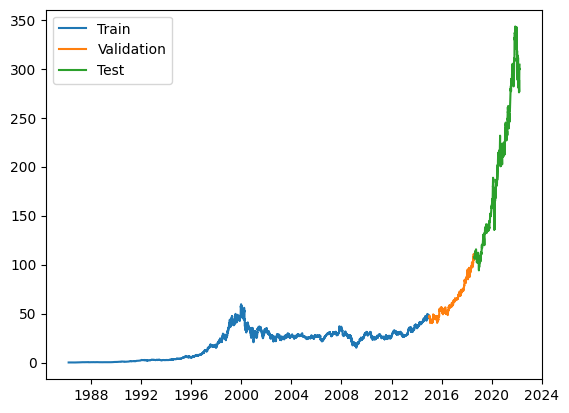

In [47]:
# Visualization
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)
plt.legend(['Train', 'Validation', 'Test'])

# 5) 1st Modeling

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [49]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

In [50]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 254.5088 - mean_absolute_error: 10.0244 - val_loss: 492.3766 - val_mean_absolute_error: 14.5865
Epoch 2/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4012 - mean_absolute_error: 0.3442 - val_loss: 389.3427 - val_mean_absolute_error: 12.2574
Epoch 3/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3088 - mean_absolute_error: 0.3329 - val_loss: 355.6331 - val_mean_absolute_error: 11.9448
Epoch 4/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3137 - mean_absolute_error: 0.3330 - val_loss: 332.2954 - val_mean_absolute_error: 10.9172
Epoch 5/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3060 - mean_absolute_error: 0.3157 - val_loss: 320.7358 - val_mean_absolute_error: 10.6616
Epoch 6/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3102 - mean_absolute_error: 0.3238 - val_loss: 308.3193 - val_mean_absolute_error: 10.3718
Epoch 7/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3281 - mea

# 6) Results

227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step


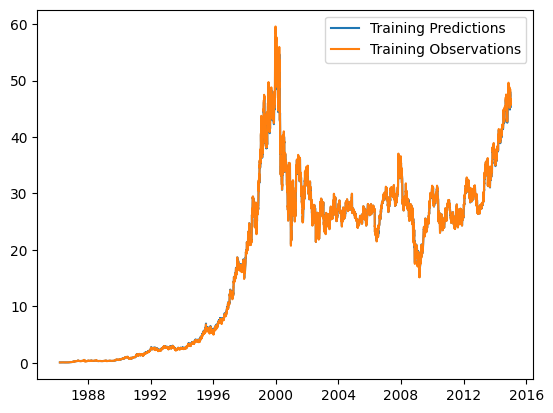

In [51]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


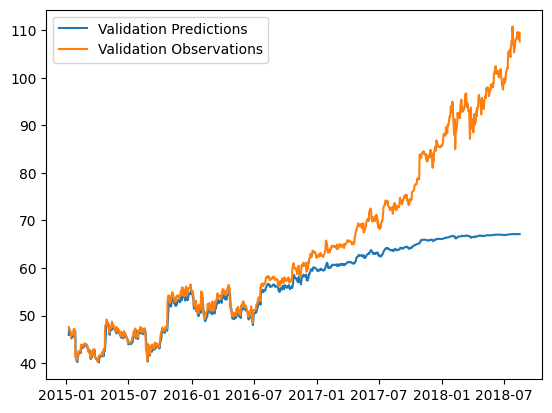

In [52]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


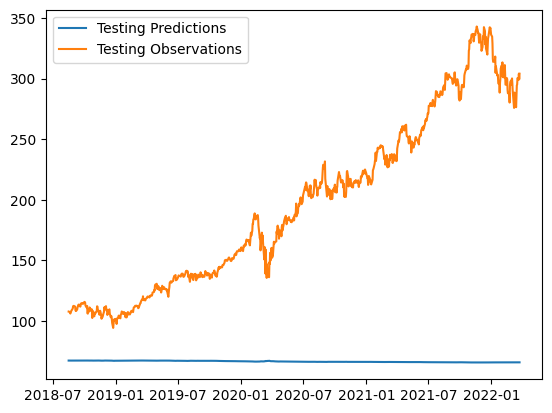

In [54]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

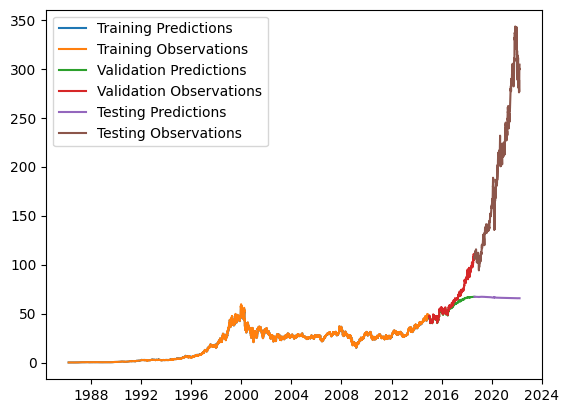

In [55]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

We note that our model correctly predicts “Closes” from 1988 to 2016. However, from 2016 onwards, the model predicts values far removed from reality. This is due to the phenomenon of extrapolation, because from 2016 onwards, the share price exploded, making the predictions biased. To obtain a more relevant result, we will train the model over a period closer to the current one(on one year period).

# 7) 2nd Modeling

In [58]:
# Start day second time around: '2021-03-25'
windowed_df_2 = df_to_windowed_df(df_mstf_copy,
                                '2021-03-25',
                                '2022-03-23',
                                n=3)
windowed_df_2

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,235.990005,237.580002,235.460007,232.339996
1,2021-03-26,237.580002,235.460007,232.339996,236.479996
2,2021-03-29,235.460007,232.339996,236.479996,235.240005
3,2021-03-30,232.339996,236.479996,235.240005,231.850006
4,2021-03-31,236.479996,235.240005,231.850006,235.770004
...,...,...,...,...,...
247,2022-03-17,276.440002,287.149994,294.390015,295.220001
248,2022-03-18,287.149994,294.390015,295.220001,300.429993
249,2022-03-21,294.390015,295.220001,300.429993,299.160004
250,2022-03-22,295.220001,300.429993,299.160004,304.059998


In [59]:
dates, X, y = windowed_df_to_date_X_y(windowed_df_2)
dates.shape, X.shape, y.shape

((252,), (252, 3, 1), (252,))

In [60]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]

dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

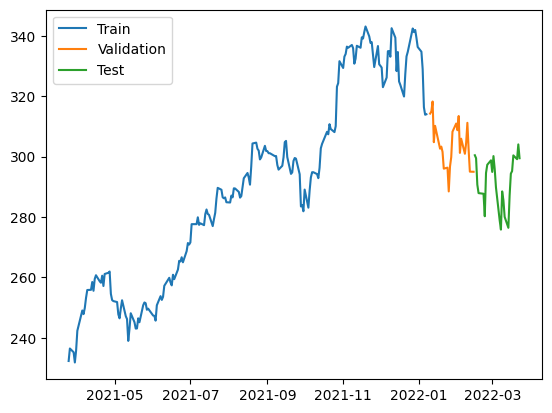

In [61]:
# Visualization
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)
plt.legend(['Train', 'Validation', 'Test'])

In [62]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 45836.4922 - mean_absolute_error: 211.4775 - val_loss: 30508.1328 - val_mean_absolute_error: 174.5097
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 19482.2988 - mean_absolute_error: 133.5577 - val_loss: 3314.3713 - val_mean_absolute_error: 57.1087
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2055.1448 - mean_absolute_error: 36.9078 - val_loss: 2063.2063 - val_mean_absolute_error: 44.8357
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4830.4409 - mean_absolute_error: 61.6277 - val_loss: 519.3237 - val_mean_absolute_error: 21.5952
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1405.2249 - mean_absolute_error: 30.9359 - val_loss: 696.7420 - val_mean_absolute_error: 25.3727
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1378.9663 - mean_absolute_error: 31.8140 - val_loss: 1573.5796 - val_mean_absolute_error: 38.9950
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1681

## Results

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


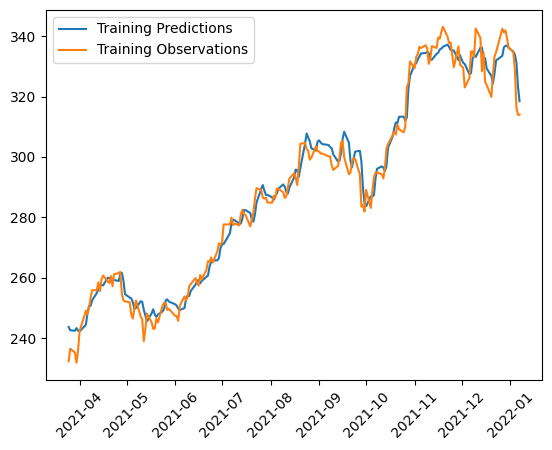

In [64]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.tick_params(axis='x', rotation=45)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


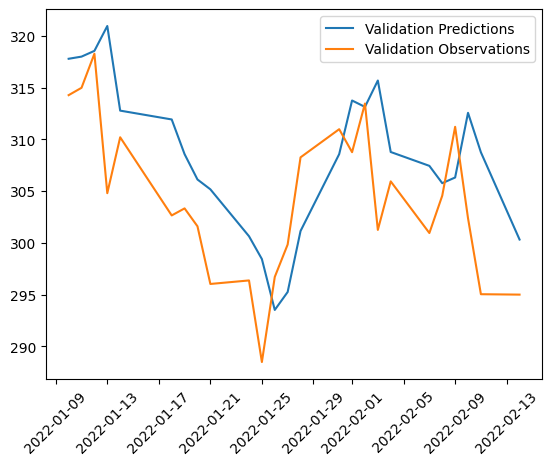

In [65]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.tick_params(axis='x', rotation=45)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


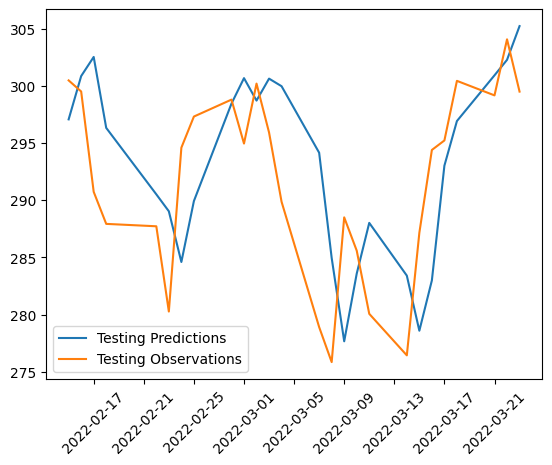

In [66]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.tick_params(axis='x', rotation=45)
plt.legend(['Testing Predictions', 'Testing Observations'])

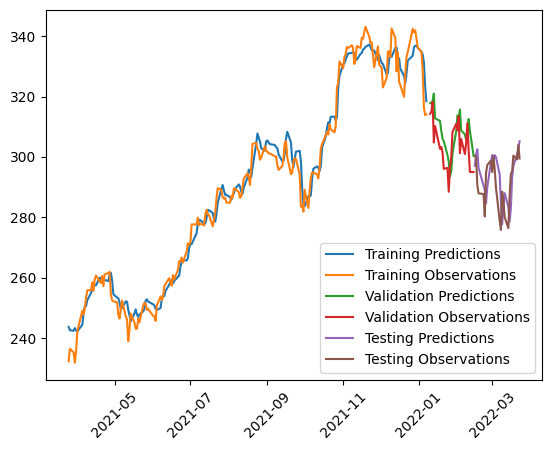

In [67]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.tick_params(axis='x', rotation=45)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

Now, all is okay ! We obtain correct predictions for this period.

Thank you !!!